In [ ]:
!pip3 install ktrain


In [2]:
import pandas as pd
pd.set_option('display.max_columns', 7)
import tensorflow as tf

# Importing Data

In [3]:
#import the data and get a sense of whats going on.
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data_challenge.csv', index_col=0)
print(data.info())
print(data.describe())

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 323125 entries, 0 to 323749
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   name           323121 non-null  object
 1   goal           323125 non-null  object
 2   sub_category   323125 non-null  object
 3   main_category  323125 non-null  object
 4   launched       323125 non-null  object
 5   deadline       323125 non-null  object
dtypes: object(6)
memory usage: 17.3+ MB
None
                            name    goal    sub_category main_category  \
count                     323121  323125          323125        323125   
unique                    321009    9070             165            15   
top     New EP/Music Development    5000  Product Design  Film & Video   
freq                          41   20649           17477         57665   

                   launched             deadline  
count                323125               323125  
unique             

In [4]:
#keep an original copy on hand for comparison.
data_original = data

# Data Cleaning


**Data Cleaning:**
Ensure all columns are in right format, no nulls or missing data, as well as no data out of valid range.



In [5]:
#Drop any rows with null entries.
print(data.isnull().sum().sum())
data= data.dropna()
print(data.isnull().sum().sum())

4
0


In [6]:
#Cast date columns as datetime objects.
data['launched']= pd.to_datetime(data['launched'],infer_datetime_format=True, errors='coerce')
data['deadline']= pd.to_datetime(data['deadline'],infer_datetime_format=True, errors='coerce')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
#New null values would form for all invalid datetime formats with errors coerced above. 
print(data.isnull().sum().sum())

12


In [8]:
#see all the invalid datetimes that were coerced.
print(data[data.isna().any(axis=1)])

                                     name                 goal  \
64484             CD: Heartsong Harmonics  2015-11-03 00:59:00   
85619                  Everyday Beautiful  2015-03-27 01:00:00   
98614               Hana Zara's new album  2015-03-03 02:04:57   
123506          Celebrating Joni Mitchell  2015-10-11 00:47:47   
159427                        Legal Highs  2014-11-05 03:00:57   
163067               Puppy Training Steps  2015-04-24 22:07:03   
177636  Adventure to Peru's Sacred Valley  2015-03-21 21:13:23   

                               sub_category main_category   launched deadline  
64484    Marc & Mary sing together at last!         Music        NaT      NaT  
85619       a day in the life of a champion  Film & Video 2000-01-01      NaT  
98614                      The North (2015)         Music        NaT      NaT  
123506       Songs by & about her + Stories         Music        NaT      NaT  
159427                   The Sobering Truth  Film & Video        NaT   

In [9]:
#Compare with original to make sure. We can see here that there was numbers and currency for date values.
print(data_original.loc[[64484,85619,98614,123506]])

                             name                 goal  \
64484     CD: Heartsong Harmonics  2015-11-03 00:59:00   
85619          Everyday Beautiful  2015-03-27 01:00:00   
98614       Hana Zara's new album  2015-03-03 02:04:57   
123506  Celebrating Joni Mitchell  2015-10-11 00:47:47   

                               sub_category main_category launched deadline  
64484    Marc & Mary sing together at last!         Music     7085      USD  
85619       a day in the life of a champion  Film & Video     2000      USD  
98614                      The North (2015)         Music     3000      USD  
123506       Songs by & about her + Stories         Music     5000      CAD  


In [10]:
#drop the invalid rows with null values from datetime conversion.
data= data.dropna()


In [11]:
#cast goals column as ints. Don't coerce errors to see if anything goes wrong.
#Without specifying a downcast, this will cast as float instead of int but at this point, I think thats Ok.
data['goal']= pd.to_numeric(data['goal'])

In [12]:
#cast the rest of the columns as strings.
for name in ['name','sub_category','main_category']:
  data[name] = data[name].astype(str)

In [14]:
#Only keep dates with launch after April 28,2009 since Kickstarter was founded on that day. 
#Wouldnt make sense to have a project on the platform before it was founded. 
#Only keep launch dates before today's date. Something cant be launching in the future.

In [13]:
mask = (data['launched'] > '2009-04-28') & (data['launched']<'2021-07-31')
data = data.loc[mask]
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323102 entries, 0 to 323749
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   name           323102 non-null  object        
 1   goal           323102 non-null  float64       
 2   sub_category   323102 non-null  object        
 3   main_category  323102 non-null  object        
 4   launched       323102 non-null  datetime64[ns]
 5   deadline       323102 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 17.3+ MB
None


In [14]:
#Only keep positive goal values, a negative goal wouldnt make sense. 
data = data.query('goal >= 0')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323102 entries, 0 to 323749
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   name           323102 non-null  object        
 1   goal           323102 non-null  float64       
 2   sub_category   323102 non-null  object        
 3   main_category  323102 non-null  object        
 4   launched       323102 non-null  datetime64[ns]
 5   deadline       323102 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), object(3)
memory usage: 17.3+ MB
None


# Preprocessing


**Preprocessing for ML:**
Create necessary abstractions, double check data types. 

In [18]:
#Dates launched and deadline as it stands seem conceptually useless. 
#The campaign length we can infer from the difference between the two might be useful.
#Coneptually, number of days in the campaign seems like a good time unit.

In [15]:
data['campaign_length']=data['deadline']-data['launched']
data['campaign_length'] = data['campaign_length'].dt.days
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323102 entries, 0 to 323749
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   name             323102 non-null  object        
 1   goal             323102 non-null  float64       
 2   sub_category     323102 non-null  object        
 3   main_category    323102 non-null  object        
 4   launched         323102 non-null  datetime64[ns]
 5   deadline         323102 non-null  datetime64[ns]
 6   campaign_length  323102 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 19.7+ MB
None


**Training NLP on Names:**

The goal of the challenge is to classify each project in its right main_category. My initial thought here was to crate a keywords abstraction of the 'name' values but since we have labeled data, we can just train a NLP engine on our specific dataset. Thus we have a "vote" for the main_category from just the name column which then acts like a normal feature along with the rest in the final model.


In [16]:
#get x as the names, and y as the main_category.
x = data.iloc[:,0].values
y = data.iloc[:,3].values

In [17]:
#create train and test split 
#random states are fine here because chronological order does not matter.
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

In [18]:
categories = sorted(data['main_category'].unique())
print(categories)

['Art', 'Comics', 'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games', 'Journalism', 'Music', 'Photography', 'Publishing', 'Technology', 'Theater']


In [19]:
#Maximum string length in names column will be used for training to avoid any unnecessary padding by BERT.
data.name.str.len().max()

96

I initially wanted to use BERT for comprehension since that's what is important here. But Distilbert preserves most of BERT's performance while being much lighter and smaller. KTrain libarary is just an easy wrapper.

In [21]:
import ktrain
from ktrain import text
model_name = 'distilbert-base-uncased'
#preprocessor for distillbert.
#Use ~96 or 100 for maxlen.
t = text.Transformer(model_name, maxlen=100, classes=categories)
training=t.preprocess_train(X_train, y_train)
validation= t.preprocess_test(X_test, y_test)
model = t.get_classifier()


/usr/local/lib/python3.7/dist-packages/ktrain/text/preprocessor.py:420: UserWarning: The class_names argument is replacing the classes argument. Please update your code.
  warnings.warn('The class_names argument is replacing the classes argument. Please update your code.')


preprocessing train...
language: en
train sequence lengths:
	mean : 6
	95percentile : 10
	99percentile : 12


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:600: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 6
	95percentile : 10
	99percentile : 12


In [26]:
#batch size of 12 seems good as a tradeoff between speed and memory.
training=t.preprocess_train(X_train[:4000], y_train[:4000])#REDEFINING TEMPORARILY FOR LR_FIND
validation= t.preprocess_test(X_test[:4000], y_test[:4000])#REDEFINING TEMPORARILY FOR LR_FIND
learner = ktrain.get_learner(model, train_data=training, val_data= validation, batch_size=12)

preprocessing train...
language: en
train sequence lengths:
	mean : 6
	95percentile : 10
	99percentile : 12


/usr/local/lib/python3.7/dist-packages/ktrain/utils.py:600: UserWarning: class_names argument was ignored, as they were extracted from string labels in dataset
  if self.get_classes(): warnings.warn('class_names argument was ignored, as they were extracted from string labels in dataset')


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 6
	95percentile : 11
	99percentile : 12


Note: I redefine training and validation to be only on the first 4000 rows just to demonstrate the graph below quickly. I ran it on the whole data set beforehand to obtain ~5e-5.

simulating training for different learning rates... this may take a few moments...
333/333 [==============================] - 43s 127ms/step - loss: 953.2333 - accuracy: 0.1688


done.
Visually inspect loss plot and select learning rate associated with falling loss


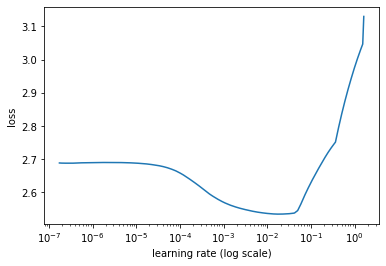

In [27]:
#see the opimized learning rate.
learner.lr_find(show_plot=True, max_epochs=1)

In [35]:
#using 1 epoch here because we don't want to wait too long, but otherwise we would use multiple.
learner.fit_onecycle(5e-5,1)



begin training using onecycle policy with max lr of 5e-05...
21541/21541 [==============================] - 3135s 143ms/step - loss: 1.1686 - accuracy: 0.6328 - val_loss: 1.0678 - val_accuracy: 0.6594


In [37]:
#set the predictor object.
predictor = ktrain.get_predictor(learner.model, preproc = t)
predictor.save('/content/drive/MyDrive/Colab Notebooks/predictor')

In [39]:
#view the biggest two classification mismatches.
learner.view_top_losses(n=2,preproc=t)

----------
id:45066 | loss:9.61 | true:Fashion | pred:Film & Video)

----------
id:42531 | loss:9.6 | true:Games | pred:Music)



In [22]:
#Reloading the predictor here for convenience.
import ktrain
predictor_reload = ktrain.load_predictor('/content/drive/MyDrive/Colab Notebooks/predictor')

In [23]:
#Testing out on a random string.
predictor_reload.predict('Super Smash Bros')


'Games'

Finally we're going to reduce the dataset to only 20,000 rows to speed things up, since this project is only for demonstration purposes. In production, I would use the whole set.

In [61]:
data= data[:20000]
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 20037
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   project_name     20000 non-null  object        
 1   goal             20000 non-null  float64       
 2   sub_category     20000 non-null  object        
 3   main_category    20000 non-null  object        
 4   launched         20000 non-null  datetime64[ns]
 5   deadline         20000 non-null  datetime64[ns]
 6   campaign_length  20000 non-null  int64         
 7   predicted_bert   4004 non-null   object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 1.4+ MB


In [ ]:
#Create the NLP "vote" column.
#important to rename the column since row.name is a native attribute, although I end up not using row.name.
data.rename(columns={'name':'project_name'}, inplace=True)
for index,row in data3.iterrows():
  data.loc[index,'predicted_bert']=predictor_reload.predict(data3.loc[index,'project_name'])
  print(index)


In [66]:
data.to_csv('/content/drive/MyDrive/Colab Notebooks/data.csv')
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 20037
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   project_name     20000 non-null  object        
 1   goal             20000 non-null  float64       
 2   sub_category     20000 non-null  object        
 3   main_category    20000 non-null  object        
 4   launched         20000 non-null  datetime64[ns]
 5   deadline         20000 non-null  datetime64[ns]
 6   campaign_length  20000 non-null  int64         
 7   predicted_bert   20000 non-null  object        
dtypes: datetime64[ns](2), float64(1), int64(1), object(4)
memory usage: 2.0+ MB
None


In [65]:
print(data.head())
print(data.tail())

                                        project_name     goal    sub_category  \
0                    The Songs of Adelaide & Abullah   1000.0          Poetry   
1                                     Where is Hank?  45000.0  Narrative Film   
2  ToshiCapital Rekordz Needs Help to Complete Album   5000.0           Music   
3  Community Film Project: The Art of Neighborhoo...  19500.0    Film & Video   
4                               Monarch Espresso Bar  50000.0     Restaurants   

   ...            deadline campaign_length predicted_bert  
0  ... 2015-10-09 11:36:00              58          Music  
1  ... 2013-02-26 00:20:50              45   Film & Video  
2  ... 2012-04-16 04:24:11              30          Music  
3  ... 2015-08-29 01:00:00              55   Film & Video  
4  ... 2016-04-01 13:38:27              35           Food  

[5 rows x 8 columns]
                                            project_name      goal  \
20033                                illustrate to paint     

In [56]:
#reload data with predictions here for convenience.
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data.csv', index_col=0)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 20037
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   project_name     20000 non-null  object 
 1   goal             20000 non-null  float64
 2   sub_category     20000 non-null  object 
 3   main_category    20000 non-null  object 
 4   launched         20000 non-null  object 
 5   deadline         20000 non-null  object 
 6   campaign_length  20000 non-null  int64  
 7   predicted_bert   20000 non-null  object 
dtypes: float64(1), int64(1), object(6)
memory usage: 1.4+ MB
None


I've decided to use RandomForest for final learning. I will explain in ML section. But the important thing at this point is to have all values as numbers since the SciKit library for random forest doesnt accept non-numeric inputs.

In [57]:
#label encoder for the name's column
#label encoder here is appropriate because there is no order to names, so we can just pseudo-hash it.
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
data['project_name']=le.fit_transform(data['project_name'])

print(data.head())
print(data.info())

   project_name     goal    sub_category  ...             deadline  \
0         17339   1000.0          Poetry  ...  2015-10-09 11:36:00   
1         19036  45000.0  Narrative Film  ...  2013-02-26 00:20:50   
2         18012   5000.0           Music  ...  2012-04-16 04:24:11   
3          4074  19500.0    Film & Video  ...  2015-08-29 01:00:00   
4         10696  50000.0     Restaurants  ...  2016-04-01 13:38:27   

  campaign_length predicted_bert  
0              58          Music  
1              45   Film & Video  
2              30          Music  
3              55   Film & Video  
4              35           Food  

[5 rows x 8 columns]
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 20037
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   project_name     20000 non-null  int64  
 1   goal             20000 non-null  float64
 2   sub_category     20000 non-null  object 
 3   main

In [63]:
#for the NLP vote, we can just cast as a category and relevant number.
#could have also used pd.get_dummies or sklearn.DictVectorizer as well.
data.predicted_bert = pd.Categorical(data.predicted_bert)
data.predicted_bert.astype('category').cat.codes
bert_dic = dict(enumerate(data['predicted_bert'].cat.categories))
data['predicted_bert'] = data.predicted_bert.cat.codes
print(bert_dic)
print(data['predicted_bert'].head())

{0: 'Art', 1: 'Comics', 2: 'Crafts', 3: 'Dance', 4: 'Design', 5: 'Fashion', 6: 'Film & Video', 7: 'Food', 8: 'Games', 9: 'Journalism', 10: 'Music', 11: 'Photography', 12: 'Publishing', 13: 'Technology', 14: 'Theater'}
0    10
1     6
2    10
3     6
4     7
Name: predicted_bert, dtype: int8


In [59]:
#for the dates, what made sense is to encode it manually. This is because order matters and something 
#like label encoder would not preserve that. 

def date2num(date_time):
  data_time=date_time.strftime("%d-%m-%Y")
  d, m, y = data_time.split('-')
  num = int(d)*10 + int(m)*100 + int(y)*1000 
  return num

#only keep dates without time component.
data['launched'] = pd.to_datetime(data['launched']).dt.date
data['deadline'] = pd.to_datetime(data['deadline']).dt.date

data['launched'] = data['launched'].apply(lambda x: date2num(x))
data['deadline'] = data['deadline'].apply(lambda x: date2num(x))

I initially used OneHotEncoder below for main_category as it would be a better choice theoretically. Unfrotunately it does not play nice with RandomForest.


y = preprocessing.OneHotEncoder().fit_transform(x).toarray()
print(y)

In [60]:
#repeat cateogirizing numerically for target column. 
data.main_category = pd.Categorical(data.main_category)
data.main_category.astype('category').cat.codes
main_cats_dic = dict(enumerate(data['main_category'].cat.categories))
print(main_cats_dic)
data['main_category'] = data.main_category.cat.codes


print(data.info())
print(data['main_category'].head())

{0: 'Art', 1: 'Comics', 2: 'Crafts', 3: 'Dance', 4: 'Design', 5: 'Fashion', 6: 'Film & Video', 7: 'Food', 8: 'Games', 9: 'Journalism', 10: 'Music', 11: 'Photography', 12: 'Publishing', 13: 'Technology', 14: 'Theater'}
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 20037
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   project_name     20000 non-null  int64   
 1   goal             20000 non-null  float64 
 2   sub_category     20000 non-null  object  
 3   main_category    20000 non-null  int8    
 4   launched         20000 non-null  int64   
 5   deadline         20000 non-null  int64   
 6   campaign_length  20000 non-null  int64   
 7   predicted_bert   20000 non-null  category
dtypes: category(1), float64(1), int64(4), int8(1), object(1)
memory usage: 1.1+ MB
None
0    12
1     6
2    10
3     6
4     7
Name: main_category, dtype: int8


# Machine Learning


I chose to use RandomForest because:


*   Prevent overfitting
*   Non paremetric with no assumptions on features.

But most importantly, it makes intuitive sense here. Otherwise kernel SVM, KNN, or a neural network could have worked just as well here.




In [66]:
from sklearn.model_selection import train_test_split
#ignoring sub_category here and target column.
x = data.iloc[:,[0,1,4,5,6,7]].values
#main_category column.
y = data.iloc[:,3].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)

In [67]:
print(x_train[:10])
print(y_train[:10])

[[8.40200e+03 2.50000e+02 2.01228e+06 2.01237e+06 8.00000e+00 5.00000e+00]
 [5.96200e+03 6.75000e+02 2.01593e+06 2.01602e+06 5.00000e+01 8.00000e+00]
 [6.66800e+03 2.00000e+03 2.01341e+06 2.01332e+06 3.00000e+01 5.00000e+00]
 [1.19340e+04 7.25000e+03 2.01219e+06 2.01228e+06 3.00000e+01 8.00000e+00]
 [1.96060e+04 7.50000e+03 2.01521e+06 2.01530e+06 3.00000e+01 6.00000e+00]
 [5.93600e+03 7.50000e+04 2.01587e+06 2.01593e+06 2.70000e+01 6.00000e+00]
 [1.23930e+04 1.50000e+04 2.01248e+06 2.01268e+06 6.00000e+01 5.00000e+00]
 [1.28000e+02 7.50000e+03 2.01467e+06 2.01477e+06 3.00000e+01 6.00000e+00]
 [1.02020e+04 2.00000e+04 2.01363e+06 2.01377e+06 3.30000e+01 1.00000e+01]
 [6.96300e+03 3.50000e+03 2.01471e+06 2.01481e+06 3.00000e+01 0.00000e+00]]
[ 5 12  5  6  6  0 10  6 10  4]


Note: scaling/standardizing these numbers is not necessary for RandomForest. Otherwise for something like SVM approach, we would have to.

For Feature selection, we will use **recursive feature elimination (RFE)**. This removes the weakest feature every iteration and ranks them by importance. This elliminates dependencies and collinearity if any exists.

In [ ]:
#In order to pick best features, we will use Rerucsive feature elimination here.
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
forest=RandomForestClassifier(verbose=1,random_state=3)

#step=1 here is the number of features it drops at a time to compare performance.
rfecv = RFECV(estimator=forest, step=1, scoring='accuracy')
rfecv.fit(x_train, y_train)

print(f"Optimal number of features : {rfecv.n_features_}")



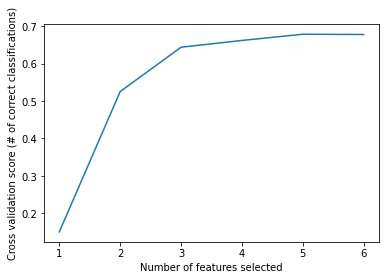

In [71]:
# Ploting the number of features vs cross-validation scores
import matplotlib.pyplot as plt

plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (# of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [72]:
#optimal number of features to use.
rfecv.n_features_

5

In [73]:
#which features it was using at peak optimality.
rfecv.support_ 

array([ True,  True,  True,  True, False,  True])

In [75]:
#seeing a list of what features were in the x column at the start.
b= list(data.columns)
indexes=[0,1,4,5,6,7]
[b[x] for x in indexes]

['project_name',
 'goal',
 'launched',
 'deadline',
 'campaign_length',
 'predicted_bert']

so it selected everything but campaign length at most effective. That means the list of features in use were: ['project_name',
 'goal',
 'launched',
 'deadline',
 'predicted_bert']

In [76]:
#get a numerical feature importance of the features that WERE USED. So not inclduing campaign length.
rfecv.estimator_.feature_importances_ 

array([0.15695161, 0.12862427, 0.14242256, 0.14300298, 0.42899858])

we can see here that the lowest contribution was from goal, the highest was predictably from 'predicted_bert'.

In [129]:
#we're going to drop campaign length here and re-run.
x = data.iloc[:,[0,1,4,5,7]].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)
print(x_train[:5])

[[8.40200e+03 2.50000e+02 2.01228e+06 2.01237e+06 5.00000e+00]
 [5.96200e+03 6.75000e+02 2.01593e+06 2.01602e+06 8.00000e+00]
 [6.66800e+03 2.00000e+03 2.01341e+06 2.01332e+06 5.00000e+00]
 [1.19340e+04 7.25000e+03 2.01219e+06 2.01228e+06 8.00000e+00]
 [1.96060e+04 7.50000e+03 2.01521e+06 2.01530e+06 6.00000e+00]]


In [135]:
print(type(x_train))

<class 'numpy.ndarray'>


In [ ]:
rfecv.fit(x_train, y_train)

print(f"Optimal number of features : {rfecv.n_features_}")

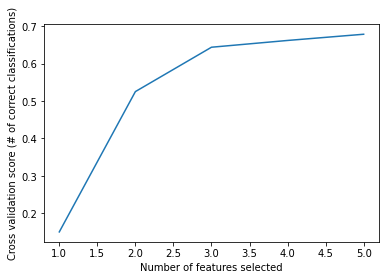

In [80]:
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (# of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [83]:
print(rfecv.support_)
b= list(data.columns)
indexes=[0,1,4,5,7]
[b[x] for x in indexes]


[ True  True  True  True  True]


['project_name', 'goal', 'launched', 'deadline', 'predicted_bert']

In [84]:
rfecv.estimator_.feature_importances_ 

array([0.15695161, 0.12862427, 0.14242256, 0.14300298, 0.42899858])

We can see that all columns contributed this time, although 'goal' again not by much and could possibly be elliminated. We'll keep it for now.

In [130]:
#now lets train our forest model on feature eliminated data.
forest.fit(x_train,y_train)
forest_predict = forest.predict(x_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


In [132]:
#saving our forest model.
import pickle
filename = '/content/drive/MyDrive/Colab Notebooks/forest_model.sav'
pickle.dump(forest,open(filename,'wb'))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


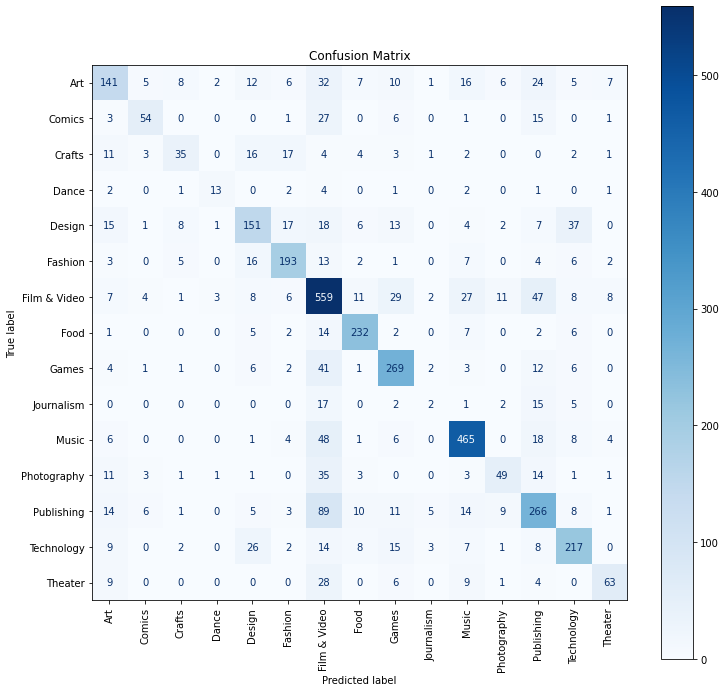





=== Classification Report ===
              precision    recall  f1-score   support

           0       0.60      0.50      0.54       282
           1       0.70      0.50      0.58       108
           2       0.56      0.35      0.43        99
           3       0.65      0.48      0.55        27
           4       0.61      0.54      0.57       280
           5       0.76      0.77      0.76       252
           6       0.59      0.76      0.67       731
           7       0.81      0.86      0.83       271
           8       0.72      0.77      0.75       348
           9       0.12      0.05      0.07        44
          10       0.82      0.83      0.82       561
          11       0.60      0.40      0.48       123
          12       0.61      0.60      0.61       442
          13       0.70      0.70      0.70       312
          14       0.71      0.53      0.60       120

    accuracy                           0.68      4000
   macro avg       0.64      0.58      0.60   

In [131]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(forest, x_test, y_test, display_labels=categories, xticks_rotation='vertical',cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
plt.show()

print('\n')
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, forest_predict))
print(main_cats_dic)
print('\n')
print("===Accuracy Score===")
print(accuracy_score(y_test,forest_predict))
print('\n')


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    3.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.1s finished


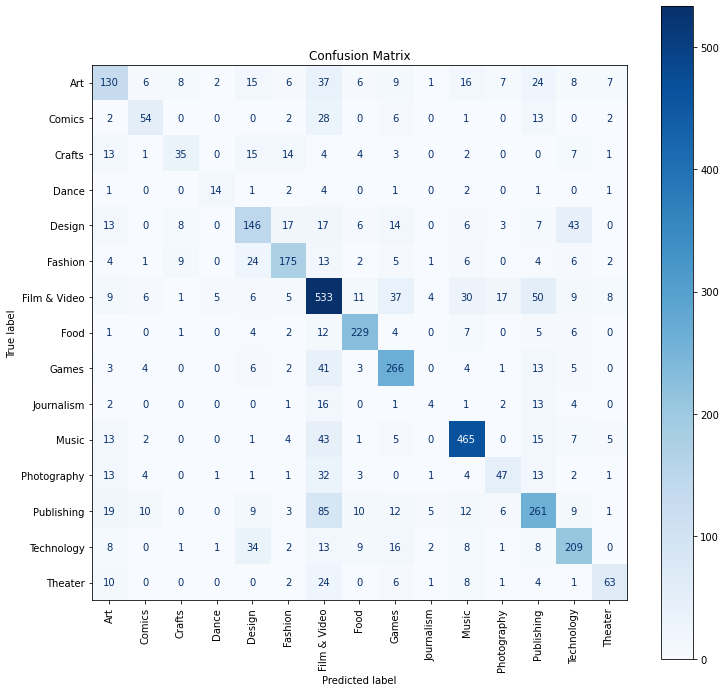





=== Classification Report ===
              precision    recall  f1-score   support

           0       0.54      0.46      0.50       282
           1       0.61      0.50      0.55       108
           2       0.56      0.35      0.43        99
           3       0.61      0.52      0.56        27
           4       0.56      0.52      0.54       280
           5       0.74      0.69      0.71       252
           6       0.59      0.73      0.65       731
           7       0.81      0.85      0.83       271
           8       0.69      0.76      0.73       348
           9       0.21      0.09      0.13        44
          10       0.81      0.83      0.82       561
          11       0.55      0.38      0.45       123
          12       0.61      0.59      0.60       442
          13       0.66      0.67      0.67       312
          14       0.69      0.53      0.60       120

    accuracy                           0.66      4000
   macro avg       0.62      0.56      0.58   

In [126]:
#And one more time without goals.
x = data.iloc[:,[0,4,5,7]].values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=50)
forest.fit(x_train,y_train)
forest_predict = forest.predict(x_test)

fig, ax = plt.subplots(figsize=(12, 12))
plot_confusion_matrix(forest, x_test, y_test, display_labels=categories, xticks_rotation='vertical',cmap=plt.cm.Blues, ax=ax)
ax.set_title('Confusion Matrix')
plt.show()

print('\n')
print('\n')
print("=== Classification Report ===")
print(classification_report(y_test, forest_predict))
print(main_cats_dic)
print('\n')
print("===Accuracy Score===")
print(accuracy_score(y_test,forest_predict))
print('\n')

As we can see, RFE correctly predicted that goals was contirbuting a little bit, and the lower accuracy score upon its ellimination is proof of that.

The accuracy from BERT's prediction was ~64%. By including other feature's and RandomForest, we were able to gain only ~3.7%. With further optimazation of parameters or choosing a different supervised learning approach, I'm confident we can push this number up to the high 70s.

# Prediction Function

In [169]:
import pickle
import ktrain
from sklearn import preprocessing
import numpy as np
import datetime

predictor_reload = ktrain.load_predictor('/content/drive/MyDrive/Colab Notebooks/predictor')

forest_model = pickle.load(open('/content/drive/MyDrive/Colab Notebooks/forest_model.sav', 'rb'))

bert_key={'Art': 0, 'Comics': 1, 'Crafts': 2, 'Dance': 3, 'Design': 4, 'Fashion': 5, 'Film & Video': 6, 'Food': 7, 'Games': 8, 'Journalism': 9, 'Music': 10, 'Photography': 11, 'Publishing': 12, 'Technology': 13, 'Theater': 14}
main_cat_keys={0: 'Art', 1: 'Comics', 2: 'Crafts', 3: 'Dance', 4: 'Design', 5: 'Fashion', 6: 'Film & Video', 7: 'Food', 8: 'Games', 9: 'Journalism', 10: 'Music', 11: 'Photography', 12: 'Publishing', 13: 'Technology', 14: 'Theater'}

def date2num(date_time):
  data_time=date_time.strftime("%d-%m-%Y")
  d, m, y = data_time.split('-')
  num = int(d)*10 + int(m)*100 + int(y)*1000 
  return num

#Input date/time format as: '2018-06-29 08:15:27.243860'
def predict_category(name,goal,launch_date,deadline_date):
  goal = float(goal)
  
  launch_date = datetime.datetime.strptime(launch_date, '%Y-%m-%d %H:%M:%S.%f')
  deadline_date = datetime.datetime.strptime(deadline_date, '%Y-%m-%d %H:%M:%S.%f')
  camp_length = (deadline_date - launch_date).days

  launch_date = date2num(launch_date)
  deadline_date = date2num(deadline_date)
 
  bert_predict = predictor_reload.predict(name)
  bert_predict = bert_key[bert_predict]
  
  #Label Encoder is not supposed to be used with unseen data since it fits on a training set
  #Taking values between 0 and n_classes-1 
  #This is a problem I realized when I got to the end here. 
  #We will just feed in a value anyway although the output from this variable will be useless.
  le = preprocessing.LabelEncoder()
  name=le.fit_transform([name])


  x=[name,goal,launch_date,deadline_date, bert_predict]
  x=np.asarray(x)
  x=x.reshape(1,-1)

  prediction = forest.predict(x)
  prediction = main_cat_keys[prediction[0]]

  return prediction 

#EXAMPLE QUERY:
predict_category('cool new fashion shorts',5070, '2018-06-29 08:15:27.243860', '2018-09-29 08:15:27.243860')



/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


'Fashion'